## The Ensemble Model. Combining the three models used till now to give the final prediction

In [1]:
import pandas as pd

section1 = pd.read_csv('section1_predictions.csv')
section2 = pd.read_csv('xgboost_ollama_predictions.csv')
section3 = pd.read_csv('section3_predictions.csv')


In [ ]:
#Combining the predictions from all three sections

merged = section1[['statement', 'label', 'predicted_percentage_true']].rename(columns={'predicted_percentage_true': 'section1_prob'})

merged = merged.merge(
    section2[['statement', 'predicted_percentage_true']].rename(columns={'predicted_percentage_true': 'section2_prob'}),
    on='statement'
)

merged = merged.merge(
    section3[['statement', 'predicted_percentage_true']].rename(columns={'predicted_percentage_true': 'section3_prob'}),
    on='statement'
)


In [ ]:
# Calculating the final probability by averaging the probabilities from all three sections giving same weightage to each model

merged['final_prob'] = (merged['section1_prob'] + merged['section2_prob'] + merged['section3_prob']) / 3

In [4]:
merged['final_prediction'] = (merged['final_prob'] > 0.55).astype(int)


In [5]:
from sklearn.metrics import accuracy_score

final_accuracy = accuracy_score(merged['label'], merged['final_prediction'])
print(f"Final Ensemble Accuracy: {final_accuracy:.4f}")


Final Ensemble Accuracy: 0.7152


### Lets try finding the best weights

In [6]:
merged.to_csv('all_predictions.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Load your merged dataframe
merged = pd.read_csv('all_predictions.csv')  # Assuming you already merged


In [ ]:
# Tring to find the best weights for the three models

best_accuracy = 0
best_weights = (0, 0, 0)

#trying weights from 0 to 1 in steps of 0.1
for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2 
        if w3 < 0:
            continue
        
        # Weighted sum of probabilities
        merged['final_prob'] = (w1 * merged['section1_prob']) + (w2 * merged['section2_prob']) + (w3 * merged['section3_prob'])
        #used confidence of 0.55 to classify the final prediction
        merged['final_prediction'] = (merged['final_prob'] > 0.55).astype(int)
        acc = accuracy_score(merged['label'], merged['final_prediction'])
        
        #best saved
        if acc > best_accuracy:
            best_accuracy = acc
            best_weights = (w1, w2, w3)

print(f"Best Accuracy: {best_accuracy:.4f} with Weights: Section1={best_weights[0]}, Section2={best_weights[1]}, Section3={best_weights[2]}")


Best Accuracy: 0.7342 with Weights: Section1=0.4, Section2=0.5, Section3=0.09999999999999998


In [9]:
merged['final_prob'] = (best_weights[0] * merged['section1_prob']) + (best_weights[1] * merged['section2_prob']) + (best_weights[2] * merged['section3_prob'])
merged['final_prediction'] = (merged['final_prob'] > 0.55).astype(int)
final_accuracy = accuracy_score(merged['label'], merged['final_prediction'])
print(f"Final Ensemble Accuracy after reweighting: {final_accuracy:.4f}")


Final Ensemble Accuracy after reweighting: 0.7342


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(merged['label'], merged['final_prediction'])
recall = recall_score(merged['label'], merged['final_prediction'])
f1 = f1_score(merged['label'], merged['final_prediction'])

print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Precision: 0.7453
Recall   : 0.7670
F1 Score : 0.7560


### Plot 3d heat map

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# To understand the effects of each model more intuitively we visualize it in 3D space.

w1_list = []
w2_list = []
acc_list = []


#online code used
# Loop over weights
for w1 in np.arange(0, 1.05, 0.05):
    for w2 in np.arange(0, 1.05 - w1, 0.05):
        w3 = 1.0 - w1 - w2
        if w3 < 0:
            continue
    
        merged['final_prob'] = (w1 * merged['section1_prob']) + (w2 * merged['section2_prob']) + (w3 * merged['section3_prob'])
        merged['final_prediction'] = (merged['final_prob'] > 0.5).astype(int)
        acc = accuracy_score(merged['label'], merged['final_prediction'])
        w1_list.append(w1)
        w2_list.append(w2)
        acc_list.append(acc)


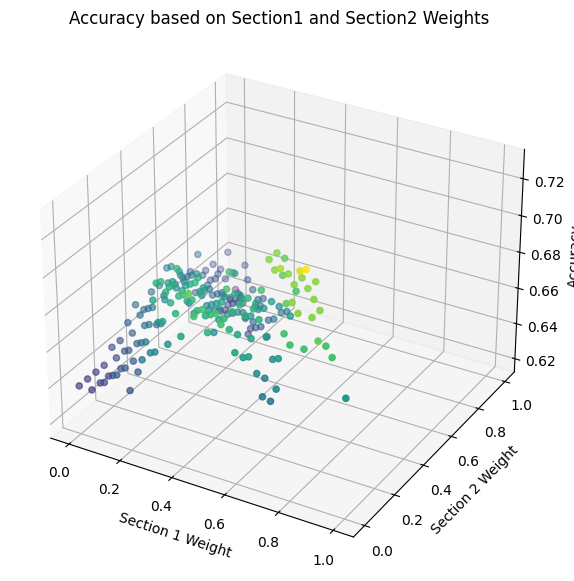

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(w1_list, w2_list, acc_list, c=acc_list, cmap='viridis')
ax.set_xlabel('Section 1 Weight')

ax.set_ylabel('Section 2 Weight')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy based on Section1 and Section2 Weights')

plt.show()
